<a href="https://colab.research.google.com/github/ny147/infant-classification/blob/pete/train_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
import shutil
#import ftransc

# For Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Infant_cry"
train_directory = path + '/data_matlab/train/'
test_directory = path + '/data_matlab/test/'

Mounted at /content/drive


# Local 

In [ ]:
# train_directory = path + '/data_matlab/train/'
# test_directory = path + '/data_matlab/test/'

In [4]:



train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=None, subset=None)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 306 files belonging to 2 classes.
Found 151 files belonging to 2 classes.
['hungry', 'non_hungry']


In [ ]:
## create model

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint

In [6]:
x_train=[]
y_train=[]
for images, labels in train_ds.unbatch().take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

In [7]:
x_test=[]
y_test=[]
for images, labels in test_ds.unbatch().take(-1):
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

In [8]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
num_classes = 2
img_height = 256
img_width = 256
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight

In [15]:
class_weights = {0:0, 1:0}
class_count = np.array([255,51])
for i in range(num_classes):
    class_weights[i]=create_weight(306,num_classes,class_count[i])

In [27]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
#x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
outputs = tf.keras.layers.Activation('sigmoid')(outputs)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 tf.cast_3 (TFOpLambda)      (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                           

In [46]:
model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 256, 256, 256)     7168      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 256)    0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 128, 128, 256)     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 128, 128, 128)     295040    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                 

In [47]:
#resnet 
#inception v3

In [48]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 8)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [49]:
# Set the epocks
# ทำ stop + validation
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights,callbacks = [earlystop_callback])

#history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 3s 403ms/step - loss: 0.7454 - accuracy: 0.6262 - val_loss: 0.6983 - val_accuracy: 0.1522
Epoch 2/30
7/7 [==============================] - 3s 387ms/step - loss: 0.7075 - accuracy: 0.2009 - val_loss: 0.6938 - val_accuracy: 0.1522
Epoch 3/30
7/7 [==============================] - 3s 372ms/step - loss: 0.7080 - accuracy: 0.8271 - val_loss: 0.6971 - val_accuracy: 0.1522
Epoch 4/30
7/7 [==============================] - 3s 367ms/step - loss: 0.7034 - accuracy: 0.1682 - val_loss: 0.6984 - val_accuracy: 0.1522
Epoch 5/30
7/7 [==============================] - 3s 367ms/step - loss: 0.7034 - accuracy: 0.1729 - val_loss: 0.6983 - val_accuracy: 0.1522
Epoch 6/30
7/7 [==============================] - 3s 370ms/step - loss: 0.7034 - accuracy: 0.1729 - val_loss: 0.6991 - val_accuracy: 0.1522
Epoch 7/30
7/7 [==============================] - 3s 371ms/step - loss: 0.7034 - accuracy: 0.1729 - val_loss: 0.6993 - val_accuracy: 0.1522
Epoch 8/30
7/7 [===============

In [51]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 15
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks = [earlystop_callback],class_weight = class_weights)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 256, 256, 256)     7168      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 256)    0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 128, 128, 256)     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 128, 128, 128)     295040    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 3s 397ms/step - loss: 0.7035 - binary_accuracy: 0.1729 - val_loss: 0.7004 - val_binary_accuracy: 0.1522
Epoch 2/15
7/7 [==============================] - 3s 370ms/step - loss: 0.7038 - binary_accuracy: 0.1729 - val_loss: 0.7004 - val_binary_accuracy: 0.1522
Epoch 3/15
7/7 [==============================] - 3s 371ms/step - loss: 0.7037 - binary_accuracy: 0.1776 - val_loss: 0.7004 - val_binary_accuracy: 0.1522
Epoch 4/15
7/7 [==============================] - 3s 370ms/step - loss: 0.7033 - binary_accuracy: 0.1729 - val_loss: 0.7004 - val_binary_accuracy: 0.1522
Epoch 5/15
7/7 [==============================] - 3s 371ms/step - loss: 0.7033 - binary_accuracy: 0.1729 - val_loss: 0.7004 - val_binary_accuracy: 0.1522
Epoch 6/15
7/7 [==============================] - 3s 373ms/step - loss: 0.7035 - binary_accuracy: 0.1776 - val_loss: 0.7004 - val_binary_accuracy: 0.1522
Epoch 7/15
7/7 [==============================] - 3s 373ms/step - loss: 0.7032 - binary

In [36]:
def binary_transform(pred):
    if pred > 0.5:
        predicted = 1
    else:
        predicted = 0
    return predicted

In [37]:
pred = model.predict(x_test)

vfunc = np.vectorize(binary_transform)
y_pred = vfunc(pred)
actual = x_test

<function matplotlib.pyplot.show>

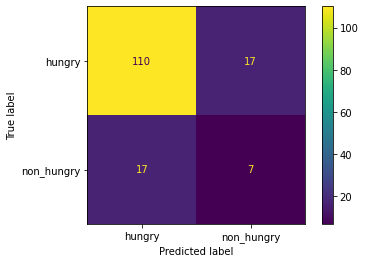

In [38]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show